In [1]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.utils import pad_sequences
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

import draft.data_cleaning as dc

In [2]:
person_0 = pd.read_json(r'datasets/december/liza.json', orient='records', lines=True) # liza
person_1 = pd.read_json(r'datasets/december/sleep_data_Adham.json', lines=True) # adham
person_2 = pd.read_json(r'datasets/december/sleep_data_Miriam.json', lines=True) # miriam
person_3 = pd.read_json(r'datasets/december/sleep_data_Syahid.json', lines=True) # syahid
person_4 = pd.read_json(r'datasets/december/sleep_data_florian.json', lines=True)  #  florian
person_5 = pd.read_json(r'datasets/december/sleep_data_Shado.json', lines=True) # shado
person_6 = pd.read_json(r'datasets/december/sleep_data_Alina.json', lines=True) # alina

# labels dataframe from excel
labels_df = pd.read_excel(r'datasets\sleep_data.xlsx', sheet_name=None) # dict of all label

In [3]:
people_df = [person_0, person_1, person_2, person_3, person_4, person_5, person_6]

for num, df in enumerate(people_df):
    df.insert(0, "temp_id", num)

people_df

[    temp_id                                      dailySleepDTO  \
 0         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 1         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 2         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 3         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 4         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 5         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 6         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 7         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 8         0  {'id': 1701986940000, 'userProfilePK': 1167901...   
 9         0  {'id': 1702078860000, 'userProfilePK': 1167901...   
 10        0  {'id': 1702171920000, 'userProfilePK': 1167901...   
 11        0  {'id': 1702254240000, 'userProfilePK': 1167901...   
 12        0  {'id': 1702340700000, 'userProfilePK': 1167901...   
 13        0  {'id': 1702425900000, 'userProfilePK': 1167901..

In [4]:
time_series_list = []

for num, df in enumerate(people_df):
    # Extrahieren der Zeitreihendaten (Annahme: gibt einen DataFrame zurück)
    temp_df = dc.main_interpolation(df)

    # Weisen Sie die eindeutige ID dem DataFrame zu
    temp_df['temp_id'] = num

    # Fügen Sie den aktualisierten DataFrame der neuen Liste hinzu
    time_series_list.append(temp_df)

len(time_series_list)

7

In [5]:
(time_series_list[4][20])

,sleepLevel_value,respirationValue,sleepRestlessMoments_value,hrvData_value,sleepStress_value,sleepBodyBattery_value,sleepHeartRate_value
startGMT,,,,,,,
2023-12-26 00:21:00,0.333333,0.714286,0.0,0.366192,0.289474,0.119565,0.326923
2023-12-26 00:22:00,0.333333,0.714286,0.0,0.366079,0.289474,0.119565,0.288462
2023-12-26 00:23:00,0.000000,0.714286,0.0,0.365966,0.289474,0.119565,0.298077
2023-12-26 00:24:00,0.000000,0.714286,0.0,0.365854,0.289474,0.119565,0.307692
2023-12-26 00:25:00,0.000000,0.714286,0.0,0.395122,0.276316,0.119565,0.307692
...,...,...,...,...,...,...,...
2023-12-26 07:36:00,0.333333,0.666667,0.0,0.326829,0.315789,0.456522,0.326923
2023-12-26 07:37:00,0.333333,0.666667,0.0,0.343902,0.377193,0.456522,0.317308
2023-12-26 07:38:00,0.333333,0.666667,0.0,0.360976,0.438596,0.456522,0.307692


In [6]:
time_series_list[0][1].shape

(542, 7)

In [7]:
# find total nights
total_nights = 0
# Durchlaufen jeder Person in der Liste
for person_index, person_data in enumerate(time_series_list):
    print(f"Person {person_index + 1}:")

    # Überprüfen, ob person_data ein Dictionary ist
    if isinstance(person_data, dict):
        # Durchlaufen jedes Nacht-DataFrames der Person
        for night, df in person_data.items():
            # Überprüfen, ob der Wert ein DataFrame ist
            if isinstance(df, pd.DataFrame):
                print(f"  Nacht {night}: {len(df)} Zeilen")
                total_nights +=1

print(total_nights)

Person 1:
  Nacht 0: 626 Zeilen
  Nacht 1: 542 Zeilen
  Nacht 2: 428 Zeilen
  Nacht 3: 359 Zeilen
  Nacht 4: 520 Zeilen
  Nacht 5: 413 Zeilen
  Nacht 6: 548 Zeilen
  Nacht 7: 667 Zeilen
  Nacht 8: 428 Zeilen
  Nacht 9: 522 Zeilen
  Nacht 10: 396 Zeilen
  Nacht 11: 541 Zeilen
  Nacht 12: 437 Zeilen
  Nacht 13: 415 Zeilen
  Nacht 14: 552 Zeilen
Person 2:
  Nacht 0: 476 Zeilen
  Nacht 1: 355 Zeilen
  Nacht 2: 344 Zeilen
  Nacht 3: 454 Zeilen
  Nacht 4: 313 Zeilen
  Nacht 5: 529 Zeilen
  Nacht 6: 254 Zeilen
  Nacht 7: 320 Zeilen
  Nacht 8: 600 Zeilen
  Nacht 9: 301 Zeilen
  Nacht 10: 584 Zeilen
  Nacht 11: 384 Zeilen
  Nacht 12: 478 Zeilen
  Nacht 13: 478 Zeilen
  Nacht 14: 434 Zeilen
  Nacht 15: 324 Zeilen
  Nacht 16: 562 Zeilen
  Nacht 17: 505 Zeilen
  Nacht 18: 394 Zeilen
Person 3:
  Nacht 0: 579 Zeilen
  Nacht 1: 313 Zeilen
  Nacht 2: 495 Zeilen
  Nacht 3: 455 Zeilen
  Nacht 4: 547 Zeilen
  Nacht 5: 481 Zeilen
  Nacht 6: 458 Zeilen
  Nacht 7: 524 Zeilen
  Nacht 8: 314 Zeilen
  Nacht 9:

In [8]:
def calculate_maximum_length(list_):
    max_length = 0  # Initialize max_length to store the maximum number of rows

    # Iterate through each person in the list
    for person_index, person_data in enumerate(time_series_list):
        # Iterate through each night DataFrame of the person
        for night, df in person_data.items():
            # Check if the value is a DataFrame
            if isinstance(df, pd.DataFrame):
                # Update max_length if this night has more rows
                if len(df) > max_length:
                    max_length = len(df)

    # After completing the iteration, max_length will hold the number of rows of the longest night
    return max_length

max_length = calculate_maximum_length(time_series_list)
max_length

994

In [9]:
"""This step is necessary because we are using convolutional layers that halve the dimensions after every layer. 
If any halve produces a .5, the ceiling will be taken. This causes the Upsampling to reproduce different dimensions that our original input. """

# Determine how many layers are in our Conv1D network. (how many times the data will be halved)
n_layers = 6

while True:
    if max_length % n_layers != 0:
        max_length += 1
    else:
        break

max_length

996

In [10]:
# List to store normalized and padded dataframes
normalized_padded_dfs = []

for person_data in time_series_list:
    for night,df in person_data.items():
        if isinstance(df, pd.DataFrame):
            # Pad them to ensure  they have the same length (needed for training/testing split)
            df_padded = pad_sequences([df.values],maxlen=max_length,dtype='float32', padding='post')
            # Add the padded dataframe to the list of normalized & padded dataframes
            normalized_padded_dfs.append((df_padded[0]))

normalized_padded_dfs[0].shape

(996, 7)

In [11]:
# Convert the list to an array
data = np.array(normalized_padded_dfs)

# Split into training and test
X_train, X_test = train_test_split(data, test_size=0.2,random_state=42)

# Define input dimensions
n_features = 7

X_train.shape

(97, 996, 7)

In [12]:
# Create model
model = keras.Sequential(
    [
        layers.Input(shape=(max_length,n_features)),
        layers.Conv1D(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Flatten(),  # Flatten the output
        layers.Reshape((125, 16)),  # Reshape to match the original shape
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=n_features, kernel_size=7, padding="same"),
        # Cropping layer to adjust the output shape exactly to 1002
        layers.Cropping1D(cropping=((2, 2))),  # Trim 3 units from start and end
    ]
)

# Define function to save embeddings
def save_embeddings(model, x_data, save_path='embeddings.npy'):
    embeddings = model.predict(x_data)
    np.save(save_path, embeddings)
    print(f'Embeddings saved to {save_path}')

 # Compile model and visualize layers
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# Print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 64)           3200      
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 249, 32)           14368     
                                                                 
 dropout_1 (Dropout)         (None, 249, 32)           0         
                                                                 
 dropout_2 (Dropout)         (None, 249, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 16)           3600      
                                                                 
 flatten (Flatten)           (None, 2000)              0

In [13]:
# Define checkpoints and early stopping
checkpoint = keras.callbacks.ModelCheckpoint('autoencoder_Conv1D.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the autoencoder
history = model.fit(
    X_train,
    X_train,
    epochs=250,
    batch_size=32,
    validation_split=0.15,
    callbacks=[
        checkpoint,
        early_stopping
    ],
)

Epoch 1/250
3/3 [==============================] - 2s 341ms/step - loss: 0.0915 - val_loss: 0.0760
Epoch 2/250
2/3 [===================>..........] - ETA: 0s - loss: 0.0671

c:\Users\ASUS\anaconda3\envs\AdvIntSys\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 119ms/step - loss: 0.0639 - val_loss: 0.0346
Epoch 3/250
3/3 [==============================] - 0s 142ms/step - loss: 0.0379 - val_loss: 0.0196
Epoch 4/250
3/3 [==============================] - 0s 91ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 5/250
3/3 [==============================] - 0s 84ms/step - loss: 0.0228 - val_loss: 0.0241
Epoch 6/250
3/3 [==============================] - 0s 80ms/step - loss: 0.0235 - val_loss: 0.0210
Epoch 7/250
3/3 [==============================] - 0s 91ms/step - loss: 0.0225 - val_loss: 0.0204
Epoch 8/250
3/3 [==============================] - 0s 126ms/step - loss: 0.0198 - val_loss: 0.0189
Epoch 9/250
3/3 [==============================] - 0s 118ms/step - loss: 0.0183 - val_loss: 0.0159
Epoch 10/250
3/3 [==============================] - 0s 82ms/step - loss: 0.0177 - val_loss: 0.0161
Epoch 11/250
3/3 [==============================] - 0s 81ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 12/250
3/3 [========

Autoencoder visualization

1/1 [==============================] - 0s 253ms/step


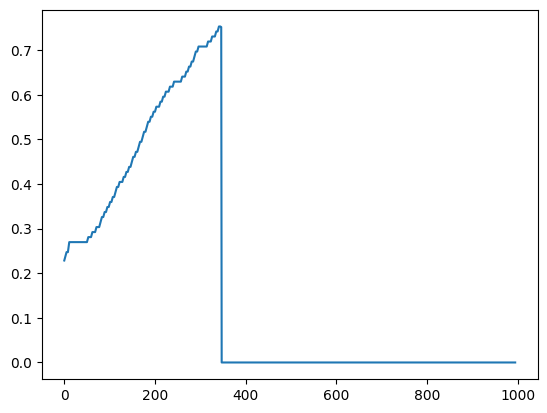

In [15]:
from matplotlib import pyplot as plt

X_test_recon = model.predict(X_test)

# 1st day in X_test, all values for the last feature
plt.plot(X_test[1,:-1,5])
plt.show()

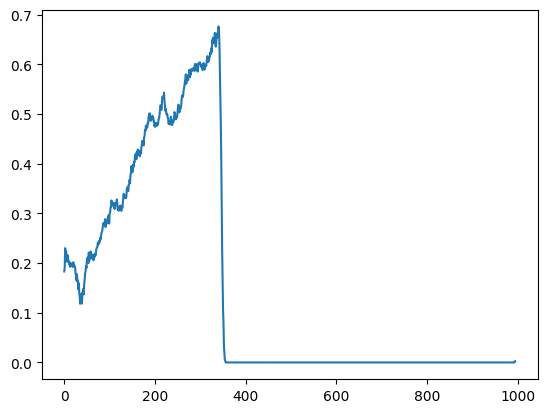

In [16]:
# 1st day in X_test_recon, all values for the second last feature
plt.plot(X_test_recon[1,:-1,5])
plt.show()

1/1 [==============================] - 0s 79ms/step
Embeddings saved to X_test_embeddings.npy


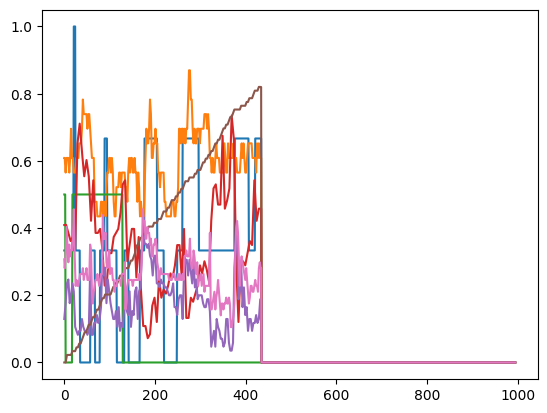

In [17]:
encoder_model = keras.models.Model(inputs= model.input, outputs=model.get_layer(index=6).output)
save_embeddings(encoder_model,X_test,save_path="X_test_embeddings.npy")
X_test_embeddings = np.load("X_test_embeddings.npy")
plt.plot(X_test[2][:-1])
plt.show()

In [18]:
X_test.shape

(25, 996, 7)

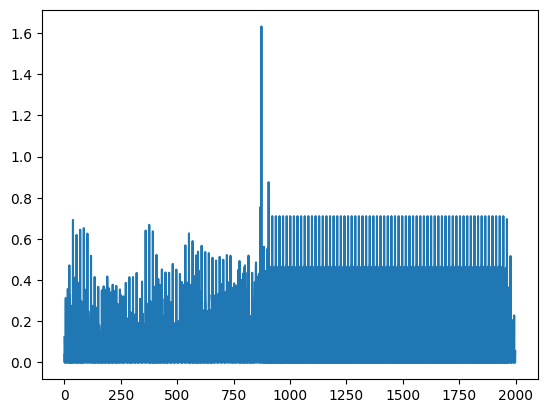

In [19]:
plt.plot(X_test_embeddings[2][:-1])
plt.show()

In [20]:
X_test_embeddings.shape

(25, 2000)

### create the embeddings

In [21]:
# Recreate the exact same model, including its weights and the optimizer
autoencoder= tf.keras.models.load_model('autoencoder_Conv1D.h5')

# get only the encoder layer
encoder = keras.models.Model(inputs= autoencoder.input, outputs=autoencoder.get_layer(index=6).output)

# Show the model architecture
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 996, 7)]          0         
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           3200      
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 249, 32)           14368     
                                                                 
 dropout_1 (Dropout)         (None, 249, 32)           0         
                                                                 
 dropout_2 (Dropout)         (None, 249, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 16)           3600

In [24]:
import os

# Create embeddings folder if it doesn't exist
if not os.path.exists(f"datasets/embeddings"):
    os.makedirs("datasets/embeddings")

# Assuming encoder and max_length are defined elsewhere
nights_embeddings = {}
for person_data in time_series_list:
    for key, value in person_data.items():
        if isinstance(value, pd.DataFrame):
            # Pad the DataFrame to ensure consistent shape
            df_padded = pad_sequences([value.values], maxlen=max_length, dtype='float32', padding='post')
            # Predict embeddings
            embeddings = encoder.predict(df_padded)
            # Store embeddings
            nights_embeddings[key] = embeddings.flatten()  # Flatten embeddings if necessary

        if key == 'temp_id':
            # Convert the embeddings dictionary to a DataFrame
            embeddings_df = pd.DataFrame.from_dict(nights_embeddings, orient='index')  # Consider 'orient' based on your data structure
            
            # Generate new column names based on the number of features in each embedding
            new_column_names = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

            # Rename the DataFrame columns
            embeddings_df.columns = new_column_names

            # Save the DataFrame as a pickle file
            file_name = f"datasets/embeddings/embeddings_{value}.pkl"
            embeddings_df.to_pickle(file_name)

            # Reset the embeddings dictionary for the next person
            nights_embeddings = {}

1/1 [==============================] - 0s 26ms/step


In [27]:
pd.read_pickle(f'datasets/embeddings/embeddings_2.pkl')

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_1990,embedding_1991,embedding_1992,embedding_1993,embedding_1994,embedding_1995,embedding_1996,embedding_1997,embedding_1998,embedding_1999
0,0.279488,0.024127,0.188463,0.0,0.0,0.178814,0.175025,0.000000,0.182342,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
1,0.196661,0.100379,0.065028,0.0,0.0,0.215623,0.270127,0.000000,0.167461,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
2,0.157962,0.111345,0.084004,0.0,0.0,0.158381,0.187640,0.000000,0.232503,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
3,0.245487,0.000000,0.107861,0.0,0.0,0.150378,0.210004,0.000000,0.158773,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
4,0.256926,0.123688,0.173867,0.0,0.0,0.229670,0.255786,0.000000,0.200450,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
5,0.041300,0.048306,0.174873,0.0,0.0,0.037738,0.294980,0.038254,0.341009,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
6,0.177880,0.144757,0.151616,0.0,0.0,0.151120,0.264503,0.000000,0.312307,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
7,0.442522,0.266434,0.284811,0.0,0.0,0.252510,0.047168,0.007921,0.204480,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
8,0.178148,0.130888,0.120792,0.0,0.0,0.162852,0.295574,0.000000,0.308893,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
9,0.000000,0.015297,0.164914,0.0,0.0,0.094665,0.510414,0.000000,0.297661,0.0,...,0.148534,0.0,0.060753,0.239468,0.0,0.0,0.029974,0.0,0.044378,0.0
